<a href="https://colab.research.google.com/github/brancatellimat/speech-emotion-recognition/blob/main/CNNClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'features:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4454614%2F7642807%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240218%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240218T093001Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D141b1f0ca864eb1146674d1679645bf6500943059360d243adf2cf3628fba00d16efaeb49826ce4b933b91f498f7b0dede00ee4a8ef5115e78c3e86d1d8a2b5a4848aec1b09a15d5ccf7730ee56da35359ad77302d336f54a01e2a3dde1a1044fc23fdeaa6cb5e7239486290844d781824b154cf00d213e9d8c235d381f894a8b83aab7962521fd157612c79f0f88055d1f163549855ff0d634b1a0185758b62c5a46970c88d03f7ad543d9d528f0dace6998252c1235e569d2d9e4dc82144ffb08806013841dbaa5a35fd32a84af3c68512052a00ace0187c8b8fad7f51d9ca982742a5f44f119924a424da7000d02aa0ee206c70bf40a63cebd3ad0ab0f94f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm

import os
import sys
import math

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import librosa.feature as libf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale, scale, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

from scipy.stats import kurtosis
from scipy.stats import skew

eps = sys.float_info.epsilon

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
features = pd.read_csv('/kaggle/input/features/features (1).csv')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.085938,0.133301,0.183105,0.187500,0.178223,0.188477,0.190918,0.193359,0.208984,0.205566,...,-14.089257,-25.075800,-3.903448,15.829265,12.395281,2.053978,1.491210,8.443647,0.892359,angry
1,0.255371,0.383301,0.500000,0.506836,0.498047,0.503418,0.514160,0.502930,0.494141,0.494629,...,-11.405813,-19.741389,-0.651677,13.968719,17.333213,6.716258,-1.127772,6.467607,3.954587,angry
2,0.083984,0.122559,0.160645,0.161621,0.162598,0.173828,0.180664,0.181152,0.188477,0.185059,...,-19.742268,-26.791355,6.480295,19.145300,8.132185,0.755440,2.556036,4.647817,-9.670603,angry
3,0.248047,0.372070,0.496582,0.504883,0.501953,0.499023,0.501953,0.492188,0.480469,0.478027,...,-17.215576,-24.751422,7.099199,17.933453,8.685198,-0.208873,4.539900,5.697086,-9.502117,angry
4,0.322754,0.488770,0.630859,0.569824,0.644531,0.702148,0.739746,0.739258,0.691406,0.623047,...,7.107078,1.137663,-10.316067,-4.229964,-0.267964,-6.191520,-8.788673,-1.441431,7.607452,disgust


In [ ]:
features=features.fillna(0)
features.shape

(33992, 2377)

In [ ]:
X = features.iloc[:, :-1]
Y = features['Emotions']

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0, shuffle=True) # 0.25 x 0.8 = 0.2

In [ ]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((20394, 2376), (6799, 2376), (6799, 2376), (20394, 6), (6799, 6), (6799, 6))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('model_weights.h5', monitor='accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((20394, 2376), (6799, 2376), (6799, 2376), (20394, 6), (6799, 6), (6799, 6))

In [ ]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_valcnn = np.expand_dims(x_val, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((20394, 2376, 1), (20394, 6), (6799, 2376, 1), (6799, 6))

In [ ]:
import tensorflow.keras.layers as L

mycnn = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
mycnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
mycnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
with tf.device(device_name):
    history=mycnn.fit(x_traincnn, y_train, epochs=100, validation_data=(x_valcnn, y_val), batch_size=32,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/100
638/638 [==============================] - 111s 174ms/step - loss: 1.3273 - accuracy: 0.4700 - val_loss: 1.3265 - val_accuracy: 0.4768 - lr: 0.0010
Epoch 2/100
638/638 [==============================] - 111s 174ms/step - loss: 1.2738 - accuracy: 0.4974 - val_loss: 1.4435 - val_accuracy: 0.4156 - lr: 0.0010
Epoch 3/100
638/638 [==============================] - 111s 174ms/step - loss: 1.2299 - accuracy: 0.5193 - val_loss: 1.2980 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 4/100
638/638 [==============================] - 111s 173ms/step - loss: 1.1731 - accuracy: 0.5453 - val_loss: 1.2461 - val_accuracy: 0.5236 - lr: 0.0010
Epoch 5/100
638/638 [==============================] - 111s 174ms/step - loss: 1.0863 - accuracy: 0.5819 - val_loss: 1.2588 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 6/100
638/638 [==============================] - 111s 174ms/step - loss: 0.9993 - accuracy: 0.6162 - val_loss: 1.1058 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 7/100
638/638 [===================

In [ ]:
loaded_cnn = keras.models.load_model('/kaggle/working/model_weights.h5')

In [ ]:
loaded_cnn

In [ ]:
  history=loaded_cnn.fit(x_traincnn, y_train, epochs=100, validation_data=(x_valcnn, y_val), batch_size=32,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/100
638/638 [==============================] - 115s 174ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.4469 - val_accuracy: 0.9073 - lr: 1.2500e-04
Epoch 2/100
638/638 [==============================] - 110s 173ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.4485 - val_accuracy: 0.9116 - lr: 1.2500e-04
Epoch 3/100
638/638 [==============================] - 110s 172ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.4540 - val_accuracy: 0.9054 - lr: 1.2500e-04
Epoch 4/100
638/638 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9980
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
638/638 [==============================] - 110s 173ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.4527 - val_accuracy: 0.9079 - lr: 1.2500e-04
Epoch 5/100
638/638 [==============================] - 110s 173ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.4444 - val_accuracy: 0.9098 - lr: 6.2500e-05
Epoch 6/100
638/638 

In [ ]:
print("Accuracy of our model on test data : " , loaded_cnn.evaluate(x_testcnn,y_test)[1]*100 , "%")

213/213 [==============================] - 10s 45ms/step - loss: 0.4613 - accuracy: 0.9122
Accuracy of our model on test data :  91.21929407119751 %


In [ ]:
# predicting on test data.
pred_test = loaded_cnn.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

213/213 [==============================] - 10s 44ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,fear,fear
2,neutral,neutral
3,fear,fear
4,angry,happy
5,fear,fear
6,neutral,neutral
7,angry,angry
8,angry,angry
9,happy,happy


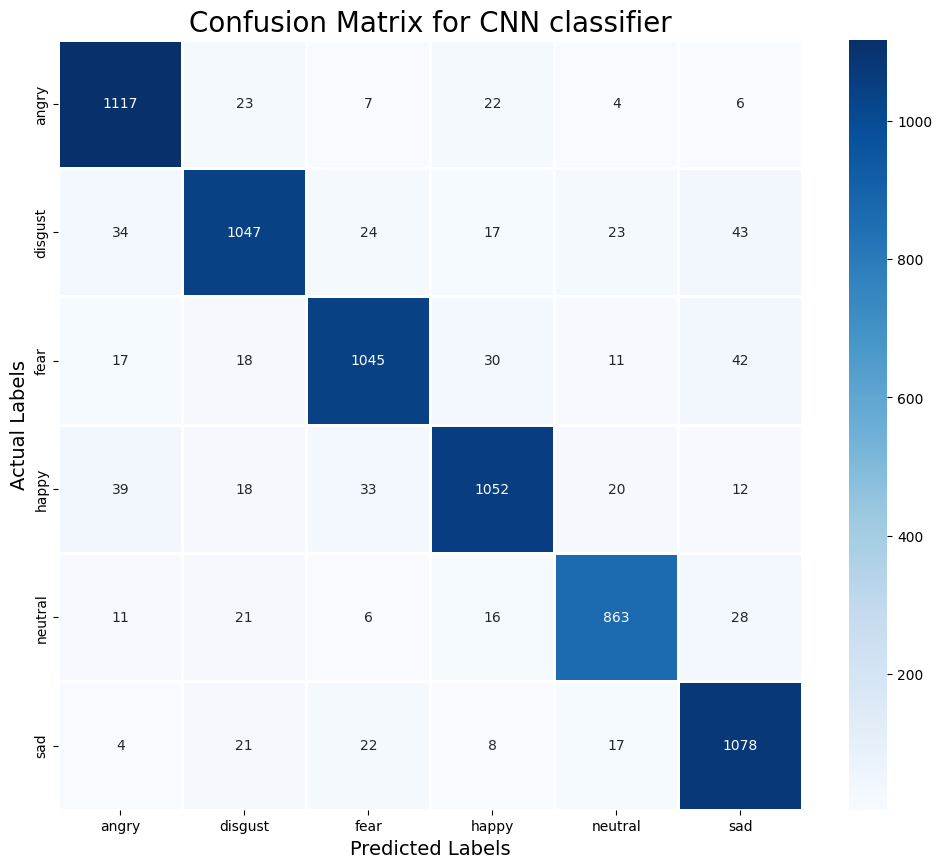

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix for CNN classifier', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
plt.savefig('CNN_cm.png')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.95      0.93      1179
     disgust       0.91      0.88      0.90      1188
        fear       0.92      0.90      0.91      1163
       happy       0.92      0.90      0.91      1174
     neutral       0.92      0.91      0.92       945
         sad       0.89      0.94      0.91      1150

    accuracy                           0.91      6799
   macro avg       0.91      0.91      0.91      6799
weighted avg       0.91      0.91      0.91      6799

